# Two-body scattering problem

The solution for the two-body scattering problem will be based on bound state and OBEpot classes. 

## Define a two-body interaction

I will work with a class that provides a method for the partial wave projection $V(p,p',l)$ of a bosonic 
interaction.   

A realistic test case is given by a OBE exchange interaction 
$$ V(\vec p, \vec p') = \frac{A}{2\pi} \frac{1}{(\vec p - \vec p')^2 + m_B^2} \exp\left(-\frac{(\vec p - \vec p')^2 + m_B^2}{\Lambda^2 }\right) + \frac{C_0}{4 \pi } \exp\left( - \frac{p^2+{p'}^2}{\Lambda^2}\right) $$ 


In [1]:
# for simplicity, we define the OBE exchange by numerical integration 
# and add one contact term to be determined using either a bound state or a scattering length 

import numpy as np
import math as m
from numpy.polynomial.legendre import leggauss
from scipy.special import legendre


class OBEpot:
    """Provides a method for the partial wave representation of the OBE potential. 
    
       The matrix elements are obtained by numerical intergration.
       The mass of the exchanged boson, the strength of the 
       interaction and the couter term is given on initialization. 
       The interaction is regularized using a cutoff that is also 
       given on init.
    """
    
    # this are common parameters for all instances 
    hbarc=197.327
    
    # init interaction
    def __init__(self, cutoff=500.0, C0=1.0, nx=12,mpi=138.0,A=-1.0):
        """Defines the one boson exchange for a given regulator, coupling strength and short distance parameter
        
        Parameters:
        cutoff -- regulator in MeV
        C0 -- strength of the short distance counter term (in s-wave) 
        A -- strength of OBE
        nx -- number of angular grid points for numerical integration
        mpi -- mass of exchange boson in MeV"""
        
        self.mpi = mpi/self.hbarc
        self.cutoff = cutoff/self.hbarc
        self.C0=C0
        self.A=A
        self.nx=nx
        
        self.xp=np.empty((self.nx),dtype=np.double)
        self.xw=np.empty((self.nx),dtype=np.double)
        self.xp,self.xw=leggauss(self.nx)
    
    
    
    # function defines the x integral 
    def _g(self,pp,p,k):
        """Calculates g function of the partial wave decomposition of OBE. 
        
           pp -- outgoing momentum 
           p -- incoming momentum
           k -- angular momentum"""
        
        # define prefact 
        # get the corresponding legendre polynomial 
        Pk = legendre(k)
        # define momentum transfer dependent on angles 
        qval=np.sqrt(p**2+pp**2-2*p*pp*self.xp)
        
        # build integral of regularized OBE 
        return float(np.sum(Pk(self.xp)/((qval**2+self.mpi**2))*self.xw*np.exp(-(qval**2+self.mpi**2)/self.cutoff**2)))
        
    # determines complete, regularized interaction     
    def v(self,pp,p,l):
        """Potential matrix element in fm**2
        
           pp -- outgoing momentum in fm**-1
           p -- incoming momentum in fm**-1
           l -- angular momentum""" 
        
        # first overall prefact of 1pi exchange part  (cancel 2pi factors!)
        prefact=self.A
        
        mat=prefact*self._g(pp,p,l)

        if (l==0):   # add s-wave counter term 
          mat+=self.C0*np.exp(-(pp**2+p**2)/self.cutoff**2)  # 4pi is take into account by spherical harmonics for l=0
                    
        return mat



We use the fits of the last lecture to determine the parameters of this OBE interaction. 

In [2]:
parasets=[[300.0, -0.09827953494014054],
 [400.0, -0.028203145146196713],
 [500.0, -0.0004221894040945335],
 [600.0, 0.012857431330421717],
 [700.0, 0.020167185806378923],
 [800.0, 0.024707945457255083],
 [900.0, 0.027865200396659445],
 [1000.0, 0.030308007813785776],
 [1100.0, 0.03239034331482156],
 [1200.0, 0.03431611357447293]]

## Repeat the bound state solver
The class for the calculation of the bound state is added to check parameters.

In [3]:
import numpy as np 
from numpy.polynomial.legendre import leggauss
from scipy.special import spherical_jn
from scipy.interpolate import interp1d

class TwoBody:
    """Methods to obtain eigenvalues and eigenvectors for the bound state problem and for searches of the binding energy."""
    # define hbarc for unit conversion 
    hbarc=197.327  
    
    def __init__(self, pot, np1=20, np2=10, pa=1.0, pb=5.0, pc=20.0, mred=938.92/2,l=0,
                            nr1=20, nr2=10, ra=1.0, rb=5.0, rc=20.0, 
                            np1four=200,np2four=100):
        """Initialization of two-body solver. 
        
           The initialization defines the momentum grids and the interaction and partial wave to be used. 
           At this time, also the grid for Fourier transformation and for the Fourier transformed 
           wave function is given. 
           
           Parameters:
           pot -- object that defines the potential matrix elements (e.g. of class OBEpot).
           np1 -- number of grid points in interval [0,pb] 
           np2 -- number of grid points in interval [pb,pc]
           pa  -- half of np1 points are in interval [0,pa]
           pb  -- interval boundary as defined above 
           pc  -- upper integration boundary for the solution of the integral equation 
           mred -- reduces mass of the two bosons in MeV
           
           nr1 -- number of r points in interval [0,rb] 
           nr2 -- number of r points in interval [rb,rc]
           ra  -- half of np1 points are in interval [0,pa]
           rb  -- interval boundary as defined above 
           rc  -- upper integration boundary for the solution of the integral equation 
           
           np1four -- number of p points in interval [0,pb] for Fourier trafo
           np2four -- number of p points in interval [pb,pc] for Fourier trafo"""
        
        # store parameters (if necessary convert to fm)
        self.np1 = np1
        self.np2 = np2
        self.npoints  = np1+np2 
        self.mred=mred/self.hbarc
        self.pa=pa
        self.pb=pb
        self.pc=pc
        self.l=l 

        self.nr1 = nr1
        self.nr2 = nr2
        self.nrpoints  = nr1+nr2 
        self.ra=ra
        self.rb=rb
        self.rc=rc

        self.np1four = np1four
        self.np2four = np2four
        self.npfour  = np1four+np2four 

        # store grid points and weights for integral equations
        self.pgrid,self.pweight = self._trns(self.np1,self.np2,self.pa,self.pb,self.pc)
 
        # store grid points and weights for r space wave functions
        self.rgrid,self.rweight = self._trns(self.nr1,self.nr2,self.ra,self.rb,self.rc)
        
        # store grid points and weights for Fourier trafo 
        self.pfourgrid,self.pfourweight = self._trns(self.np1four,self.np2four,self.pa,self.pb,self.pc)
        
        # store underlying interaction
        self.pot=pot
        
    def _trns(self,np1,np2,pa,pb,pc):
      """Auxilliary method that provides transformed Gaus-Legendre grid points and integration weights.
      
         This is using a hyperbolic trafo shown in the lecture. 
         Parameter: 
         np1 --  grid points in ]0,pb[
         np2 --  grid points are distributed in ]pb,pc[ using a linear trafo
         
         pa  -- half of np1 points are in interval [0,pa]
         pb  -- interval boundary as defined above 
         pc  -- upper integration boundary """ 
    
      x1grid,x1weight=leggauss(np1)
      x2grid,x2weight=leggauss(np2)

      # trafo (1.+X) / (1./P1-(1./P1-2./P2)*X) for first interval 
      p1grid=(1.+x1grid) / (1./pa-(1./pa-2./pb)*x1grid)
      p1weight=(2.0/pa-2.0/pb)*x1weight / (1./pa-(1./pa-2./pb)*x1grid)**2

      # linear trafo 
      p2grid=(pc+pb)/2.0 + (pc-pb)/2.0*x2grid
      p2weight=(pc-pb)/2.0*x2weight
   
      pgrid=np.empty((self.npoints),dtype=np.double)
      pweight=np.empty((self.npoints),dtype=np.double)
    
      pgrid = np.concatenate((p1grid, p2grid), axis=None)
      pweight = np.concatenate((p1weight, p2weight), axis=None)
   
      return pgrid,pweight 

# set up set of equations and calculate eigenvalues 

    def eigv(self,E,neigv):
      """Solve two-body integral equation and return n-th eigenvalue, momentum grid and wave function. 

         Parameters:
         E -- energy used in the integral equation in fm**-1 
         neigv -- number of the eigenvalue to be used"""
   
    # set up the matrix amat for which eigenvalues have to be calculated 
      amat=np.empty((self.npoints,self.npoints),dtype=np.double)
      for i in range(self.npoints):
        for j in range(self.npoints): 
          amat[i,j]=np.real(1.0/(E-self.pgrid[i]**2/(2*self.mred))*self.pot.v(self.pgrid[i],self.pgrid[j],self.l)*self.pweight[j]*self.pgrid[j]**2)

    # determine eigenvalues using numpy's eig method        
      evalue,evec=np.linalg.eig(amat)
    
    # I now assume that the relevant eigenvalues are real to avoid complex arithmetic 
      evalue=np.real(evalue)
        
    # remove neigv-1 largest eigenvalues 
      for n in range(neigv-1):
        maxpos=np.argmax(evalue)
        evalue[maxpos]=0.0
    
    # take the next one 
      maxpos=np.argmax(evalue)
      eigv=evalue[maxpos]
    # define solution as unnormalized wave function 
      wf=evec[:,maxpos]
    # and normalize 
      norm=np.sum(wf**2*self.pweight[0:self.npoints]*self.pgrid[0:self.npoints]**2)
      wf=1/np.sqrt(norm)*wf
    
      return eigv,self.pgrid[0:self.npoints],wf

    
    def esearch(self,neigv=1,e1=-0.01,e2=-0.0105,elow=0.0,tol=1e-8):
        """Perform search for energy using the secant method. 
        
           Parameters:
           neigv -- number of the eigenvalue to be used
           e1 -- first estimate of binding energy (should be negative)
           e2 -- second estimate of binding energy (should be negative)
           elow -- largest energy to be used in search (should be negative)
           tol -- if two consecutive energies differ by less then tol, the search is converged
           
           Energies are given in fm**-1. """
        
        # determine eigenvalues for starting energies        
        eta1,pgrid,wf=self.eigv(e1,neigv)
        eta2,pgrid,wf=self.eigv(e2,neigv)
        
        while abs(e1-e2) > tol: 
          # get new estimate (taking upper value into account)   
          enew=e2+(e1-e2)/(eta1-eta2)*(1-eta2) 
          enew=min(elow,enew)
       
          # get new eigenvalue and replace e1 and e2 for next iteration
          eta,pgrid,wf=self.eigv(enew,neigv)
          e2=e1
          eta2=eta1
          e1=enew
          eta1=eta 
            
        return e1,eta1,pgrid,wf 
           
    def fourier(self,wfp):
        """Calculates the Fourier transform of the partial wave representation of the wave function.
        
           Parameter: 
           wfp -- wave function in momentum space
            
           Note that the factor I**l is omitted."""
        
        # calculate spherical bessel functions based dense Fourier trafo momentum grid and rgrid
        # prepare matrix based on r,p points  
        rpmat = np.outer(self.rgrid,self.pfourgrid)
        # evaluate jl     
        jlmat = spherical_jn(self.l,rpmat)
        
        # interpolate of wave to denser Fourier trafo grid
        wfinter = interp1d(self.pgrid, wfp, kind='cubic',fill_value="extrapolate")
        # interpolate wf and multiply my p**2*w elementwise 
        wfdense = wfinter(self.pfourgrid)*self.pfourgrid**2*self.pfourweight*np.sqrt(2/m.pi)
        
        # now the Fourier trafo is a matrix-vector multiplication 
        wfr = jlmat.dot(wfdense)
        
        return self.rgrid,wfr
    
    
    def rms(self,wfr):
        """Calculates the norm and rms radius for the given r-space wave function.
        
           Normalization of the wave function is assumed. 
           Parameter: 
           wfr -- wave function in r-space obtained by previous Fourier trafo"""
        
        
        norm=np.sum(wfr**2*self.rweight*self.rgrid**2)
        rms=np.sum(wfr**2*self.rweight*self.rgrid**4)

            
        rms=np.sqrt(rms)
        
        return norm,rms
    
    
        

Use this to calc binding energies ...

In [4]:
# go through parameters of fit
for para in parasets:
    # determine interacion and set up solver 
    pot=OBEpot(nx=24,mpi=138.0,C0=para[1],A=-1.0/6.474860194946856,cutoff=para[0])
    solver=TwoBody(pot=pot,np1=40,np2=20,pa=1.0,pb=7.0,pc=35.0,mred=938.92/2,l=0,
                            nr1=40, nr2=20, ra=1.0, rb=5.0, rc=20.0, 
                            np1four=400,np2four=200)
    
    # perform energy search for this parameter set
    ener,lam,pmom,wf=solver.esearch(neigv=1,e1=-2.0/TwoBody.hbarc,e2=-2.5/TwoBody.hbarc)
    
    # get Fourier trafo (together with r grid points)
    rp,wfr=solver.fourier(wf)
    # calculate norm and rms radius (deviation of the norm from 1 gives idea of accuracy)
    norm,rms=solver.rms(wfr)
    
    # print energy, eigenvalue (should be one), norm and 1/2 rms (= radius to the CM for equal mass particles)
    print("{0:15.6e}   {1:15.6e}  {2:15.6e}   {3:15.6e}".format(ener*TwoBody.hbarc,lam, norm, rms/2.0)) #rms is printed for distance to CM assuming equal masses



  -2.224997e+00      1.000000e+00  9.997794e-01+0.000000e+00j   2.096766e+00+0.000000e+00j
  -2.224993e+00      1.000000e+00  9.997841e-01+0.000000e+00j   2.069329e+00+0.000000e+00j
  -2.224990e+00      1.000000e+00  9.997849e-01+0.000000e+00j   2.064349e+00+0.000000e+00j
  -2.224991e+00      1.000000e+00  9.997849e-01+0.000000e+00j   2.064681e+00+0.000000e+00j
  -2.224992e+00      1.000000e+00  9.997846e-01+0.000000e+00j   2.066091e+00+0.000000e+00j
  -2.224992e+00      1.000000e+00  9.997844e-01+0.000000e+00j   2.067504e+00+0.000000e+00j
  -2.224993e+00      1.000000e+00     9.997843e-01      2.068679e+00
  -2.224994e+00      1.000000e+00  9.997842e-01+0.000000e+00j   2.069602e+00+0.000000e+00j
  -2.224994e+00      1.000000e+00  9.997841e-01+0.000000e+00j   2.070315e+00+0.000000e+00j
  -2.224991e+00      1.000000e+00  9.997840e-01+0.000000e+00j   2.070864e+00+0.000000e+00j


looks good! 

## Two-Body scattering

The implementation is done as an extension of the bound state class so that some of the previous routines can be reused. 
The initialization just adds points for the onshell point.

In [5]:
# next extend the class for twobody to scattering 
from scipy.special import legendre

class TwoBodyScatt(TwoBody):
    
    def __init__(self, pot, np1=20, np2=10, pa=1.0, pb=5.0, pc=20.0, mred=938.92/2,l=0,
                            nr1=20, nr2=10, ra=1.0, rb=5.0, rc=20.0, 
                            np1four=200,np2four=100):
        
        
        # first use the TwoBody class to keep the main parameters 
        super().__init__(pot,np1,np2,pa,pb,pc,mred,l,nr1,nr2,ra,rb,rc,np1four,np2four)

        # append one momentum to grid for the onshell value
        # value will be defined during solution in lseq below
        self.pgrid=np.append(self.pgrid,[0.0])
        self.pweight=np.append(self.pweight,[0.0])
        
# now turn to scattering and solve for LS equation to get tmatrix (on- and offshell)
    def lseq(self,E):
      # set up equations for bound state
    
      # on-shell momentum  
      pon=np.sqrt(2*self.mred*E)
      self.pgrid[self.npoints]=pon
        
      # define matrix for set of equations 
      # predefine the Kronecker deltas 
      amat=np.identity(self.npoints+1,dtype=np.cdouble)
      # now add the other pieces of the definition of the matrix   
      for i in range(self.npoints+1):
        # first for j != N 
        for j in range(self.npoints):   
          amat[i,j]+=-(2*self.mred)*self.pot.v(self.pgrid[i],self.pgrid[j],self.l)*self.pgrid[j]**2 \
                               /(pon**2-self.pgrid[j]**2)*self.pweight[j]  \
        # then for j==N              
        amat[i,self.npoints]  \
           +=(2*self.mred)*self.pot.v(self.pgrid[i],pon,self.l)*pon**2* \
                 np.sum(self.pweight[0:self.npoints-1]/(pon**2-self.pgrid[0:self.npoints-1]**2))  \
             +1j*m.pi*self.mred*pon*self.pot.v(self.pgrid[i],pon,self.l)  \
             -self.mred*pon*self.pot.v(self.pgrid[i],pon,self.l)*np.log(abs((pon+self.pc)/(self.pc-pon)))
        
      # now define the rhs   
      bmat=np.empty((self.npoints+1,self.npoints+1),dtype=np.cdouble)
      for i in range(self.npoints+1):
        for j in range(self.npoints+1):   
            bmat[i,j]=self.pot.v(self.pgrid[i],self.pgrid[j],self.l)
            
      # finally solve set of equations 
      tmat=np.linalg.solve(amat,bmat)
        
      # return onshell matrix element  
      return tmat[self.npoints,self.npoints]
    
    def wq(self,tonshell,theta):
      """Calculates differential cross section based on list of tmatrix elements. 
      
         Parameter: 
         tonshell -- list of complex pw matrix elements of the t-matrix. Maximum l is len(tonshell)-1.
         theta -- array of angles in rad for which the wq needs to be calculated.
         
         Returns array of the cross section values for the different theta. 
         
      """
   
      tmatsum=np.zeros((len(theta)),dtype=np.cdouble)
      xval=np.cos(theta)
        
      for l in range(len(tonshell)):
        leg=legendre(l)
        tmatsum+=(2*l+1)*leg(xval)*tonshell[l]
        
        
      return m.pi**2*self.mred**2*np.abs(tmatsum)**2    

To test, I first try to confirm independence of the result on the set of parameters. I will later only use the one for $\Lambda = 800$ MeV.

[[Model]]
    Model(_eval)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 10
    # variables        = 3
    chi-square         = 1.4165e-12
    reduced chi-square = 2.0235e-13
    Akaike info crit   = -289.854505
    Bayesian info crit = -288.946750
[[Variables]]
    a:  5.74253075 +/- 1.7447e-05 (0.00%) (init = 5)
    r:  2.08948182 +/- 1.8327e-04 (0.01%) (init = 1)
    C: -0.26873941 +/- 0.00336677 (1.25%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(r, C) = -0.975
    C(a, r) = -0.909
    C(a, C) =  0.814
[[Model]]
    Model(_eval)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 17
    # data points      = 10
    # variables        = 3
    chi-square         = 1.6647e-12
    reduced chi-square = 2.3782e-13
    Akaike info crit   = -288.239471
    Bayesian info crit = -287.331716
[[Variables]]
    a:  5.67092958 +/- 1.8446e-05 (0.00%) (init = 5)
    r:  1.98914803 +/- 1.9

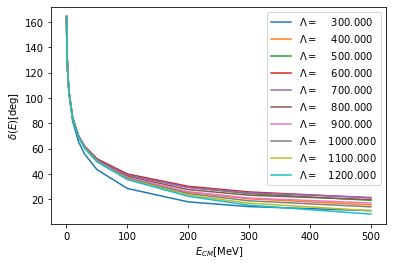

In [10]:
# go through parameters of fit now for scattering 
# libaries for plotting
# numpy is used for the solution anyhow 
import matplotlib.pyplot as plt
import numpy as np
from lmfit.models import ExpressionModel

# set number of energies used for extraction of a,r 
numk=10

# prepare parameters 
# get figure enviroment 
fig, ax = plt.subplots()

# set labels 
ax.set_xlabel(r'$E_{CM}$[MeV]')
ax.set_ylabel(r'$\delta(E)$[deg]')

# set some limits on axes to concentrate on most relevant part of the interaction. 

#ax.set_xlim(0,100)
#ax.set_ylim(1E-6,15)

energies=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,2,4,10,20,30,50,100,200,300,500]
for para in parasets:
    # determine interacion and set up solver 
    pot=OBEpot(nx=24,mpi=138.0,C0=para[1],A=-1.0/6.474860194946856,cutoff=para[0])
    fbsolver=TwoBodyScatt(pot=pot,np1=40,np2=20,pa=1.0,pb=7.0,pc=35.0,mred=938.92/2,l=0,
                            nr1=40, nr2=20, ra=1.0, rb=5.0, rc=20.0, 
                            np1four=400,np2four=200)
    
    plt_delta=[]
    for ener in energies:
      # perform energy search for this parameter set
      tonshell=fbsolver.lseq(ener/TwoBody.hbarc)
      smat=1-1j*938.92/197.327*m.pi*np.sqrt(ener*938.92/TwoBody.hbarc**2)*tonshell
      delta=np.real(-0.5*1j*np.log(smat))*180.0/m.pi  
      if ener < 10 and delta < 0:
         delta+=180.0
    
      plt_delta.append(delta)
        
      # print phase shift 
      # print("{3:15.3f} {0:15.6e}   {1:15.6e}  {2:15.6e}".format(ener,delta,np.abs(smat),para[0]))

    # phase shifts for one energie are collected 
    # plot these phases 
    ax.plot(energies,plt_delta,label=r"$\Lambda=$ {0:10.3f}".format(para[0]))

    
    # now use the first n phases to determine a,r
    # calc momenta from CM energies
    deltarad=np.array(plt_delta)*m.pi/180.0
    eval=np.array(energies)/TwoBody.hbarc
    k=np.sqrt(938.92/TwoBody.hbarc*eval)
    kcotdelta=k/np.tan(deltarad)

    mod = ExpressionModel('-1/a+0.5*r*x**2+C*x**4')
    res = mod.fit(kcotdelta[0:numk], a=5,C=0,r=1, x=k[0:numk])
    print(res.fit_report())
    
    
ax.legend(loc="best")
    
fig.savefig("phases.pdf")    





Looks good, too! This was not requested in the exercise.

Now turn to check of stability.
Start with number of grid points. 

In [ ]:
para=[800.0, 0.024707945457255083]
pot=OBEpot(nx=24,mpi=138.0,C0=para[1],A=-1.0/6.474860194946856,cutoff=para[0])

pa=1.0
pb=7.0
pc=35.0
ener=1.0
for np1 in [20,30,40,50]:
  for np2 in [10,20,30]:
     fbsolver=TwoBodyScatt(pot=pot,np1=np1,np2=np2,pa=pa,pb=pb,pc=pc,mred=938.92/2,l=0,nr1=40, nr2=20, ra=1.0, rb=5.0, rc=20.0, np1four=400,np2four=200)
     tonshell=fbsolver.lseq(ener/TwoBody.hbarc)
     print("{0:5d} &  {1:5d} &  {2:15.1f} & {3:15.1f} & {4:15.1f}  & {5:15.6e}  + I ({6:15.6e}) \\\\".format(np1,np2,pa,pb,pc,np.real(tonshell),np.imag(tonshell)))

Now check the same for the upper bound. 

In [ ]:
para=[800.0, 0.024707945457255083]
pot=OBEpot(nx=24,mpi=138.0,C0=para[1],A=-1.0/6.474860194946856,cutoff=para[0])

np1=20
np2=30
pa=1.0
pb=7.0
pc=35.0
ener=1.0
for pc in [15.0,20.0,30.0,35.0,40.0]:
     fbsolver=TwoBodyScatt(pot=pot,np1=np1,np2=np2,pa=pa,pb=pb,pc=pc,mred=938.92/2,l=0,nr1=40, nr2=20, ra=1.0, rb=5.0, rc=20.0, np1four=400,np2four=200)
     tonshell=fbsolver.lseq(ener/TwoBody.hbarc)
     print("{0:5d} &  {1:5d} &  {2:15.1f} & {3:15.1f} & {4:15.1f}  & {5:15.6e}  + I ({6:15.6e}) \\\\".format(np1,np2,pa,pb,pc,np.real(tonshell),np.imag(tonshell)))

Now change the definition of $A$-matrix  so  that the limit $p_{max}$ is done for the principal value part. And repeat 
the calculation

In [ ]:
para=[800.0, 0.024707945457255083]
pot=OBEpot(nx=24,mpi=138.0,C0=para[1],A=-1.0/6.474860194946856,cutoff=para[0])

np1=20
np2=30
pa=1.0
pb=7.0
pc=35.0
ener=1.0
for pc in [15.0,20.0,30.0,35.0,40.0]:
     fbsolver=TwoBodyScatt(pot=pot,np1=np1,np2=np2,pa=pa,pb=pb,pc=pc,mred=938.92/2,l=0,nr1=40, nr2=20, ra=1.0, rb=5.0, rc=20.0, np1four=400,np2four=200)
     tonshell=fbsolver.lseq(ener/TwoBody.hbarc)
     print("{0:5d} &  {1:5d} &  {2:15.1f} & {3:15.1f} & {4:15.1f}  & {5:15.6e}  + I ({6:15.6e}) \\\\".format(np1,np2,pa,pb,pc,np.real(tonshell),np.imag(tonshell)))

Now switch back to correct implementation! 

In [ ]:
np1=20
np2=30
pa=1.0
pb=7.0
pc=35.0
ener=10.0

fbsolver=TwoBodyScatt(pot=pot,np1=np1,np2=np2,pa=pa,pb=pb,pc=pc,mred=938.92/2,l=0,nr1=40, nr2=20, ra=1.0, rb=5.0, rc=20.0, np1four=400,np2four=200)
tonshell=fbsolver.lseq(ener/TwoBody.hbarc)
print("{0:5d} &  {1:5d} &  {2:15.1f} & {3:15.1f} & {4:15.1f}  & {5:15.6e} \\\\".format(np1,np2,pa,pb,pc,np.abs(1-1j*938.92/TwoBody.hbarc*np.sqrt(ener*938.92/TwoBody.hbarc**2)*m.pi*tonshell)))

Unitarity is reproduced with machine precision! Very good!  (I checked 1 and 10 MeV) 

In [ ]:
# go through parameters of fit now for scattering 
# libaries for plotting
# numpy is used for the solution anyhow 
import matplotlib.pyplot as plt
import numpy as np

# prepare parameters 
# get figure enviroment 
fig, ax = plt.subplots()

# set labels 
ax.set_xlabel(r'$E_{CM}$[MeV]')
ax.set_ylabel(r'$\delta(E)$[deg]')

# set some limits on axes to concentrate on most relevant part of the interaction. 

#ax.set_xlim(0,100)
#ax.set_ylim(1E-6,15)

energies=[1,2,4,10,20,30,50,60,70,80,90,100,110,120,130,140,150,160,170,180,190,200]
# determine interacion and set up solver 
pot=OBEpot(nx=24,mpi=138.0,C0=para[1],A=-1.0/6.474860194946856,cutoff=para[0])
fbsolver=TwoBodyScatt(pot=pot,np1=40,np2=20,pa=1.0,pb=7.0,pc=35.0,mred=938.92/2,l=0,
                            nr1=40, nr2=20, ra=1.0, rb=5.0, rc=20.0, 
                            np1four=400,np2four=200)
    
plt_delta=[]
for ener in energies:
# perform energy search for this parameter set
  tonshell=fbsolver.lseq(ener/TwoBody.hbarc)
  smat=1-1j*938.92/197.327*m.pi*np.sqrt(ener*938.92/TwoBody.hbarc**2)*tonshell
  delta=np.real(-0.5*1j*np.log(smat))*180.0/m.pi  

#now comes the correction part for negative phase shifts close to zero 
  if ener < 10 and delta < 0:
    delta+=180.0
    
  plt_delta.append(delta)
        
# print phase shift 
  print("{3:15.3f} {0:15.6e}   {1:15.6e}  {2:15.6e}".format(ener,delta,np.abs(smat),para[0]))

# phase shifts for one energie are collected 
# plot these phases 
ax.plot(energies,plt_delta,label=r"$\Lambda=$ {0:10.3f}".format(para[0]))
        
ax.legend(loc="best")
    
fig.savefig("phase.lam=800.pdf")  

In [ ]:
# go through parameters of fit now for scattering 
# libaries for plotting
# numpy is used for the solution anyhow 
import matplotlib.pyplot as plt
import numpy as np

# prepare parameters 
# get figure enviroment 
fig, ax = plt.subplots()

# set labels 
ax.set_xlabel(r'$\theta$[deg]')
ax.set_ylabel(r'$d\sigma/d\hat p$[fm$^2$]')

# set some limits on axes to concentrate on most relevant part of the interaction. 

#ax.set_xlim(0,100)
#ax.set_ylim(1E-6,15)

ener=10.0
# determine interacion and set up solver 
pot=OBEpot(nx=24,mpi=138.0,C0=para[1],A=-1.0/6.474860194946856,cutoff=para[0])

tonshell=[]
for l in range(7):
  fbsolver=TwoBodyScatt(pot=pot,np1=40,np2=20,pa=1.0,pb=7.0,pc=35.0,mred=938.92/2,l=l,
                            nr1=40, nr2=20, ra=1.0, rb=5.0, rc=20.0, 
                            np1four=400,np2four=200)
# perform energy search for this parameter set
  tval=fbsolver.lseq(ener/TwoBody.hbarc)
  tonshell.append(tval) 


theta=np.linspace(0,180,100)

for lmax in range(len(tonshell)):
  wq=fbsolver.wq(tonshell[0:lmax],theta/180.0*m.pi)
  ax.semilogy(theta,wq,label=r"$\Lambda=$ {0:10.3f} lmax={1:3d}".format(para[0],lmax))
        
ax.legend(loc="best")
    
fig.savefig("wq-e=10.0-lam=800.pdf")  

In [ ]:
# go through parameters of fit now for scattering 
# libaries for plotting
# numpy is used for the solution anyhow 
import matplotlib.pyplot as plt
import numpy as np

# prepare parameters 
# get figure enviroment 
fig, ax = plt.subplots()

# set labels 
ax.set_xlabel(r'$E_{CM}$[MeV]')
ax.set_ylabel(r'$\delta(E)$[deg]')

# set some limits on axes to concentrate on most relevant part of the interaction. 

#ax.set_xlim(0,100)
#ax.set_ylim(1E-6,15)

energies=[1,2,4,10,20,30,50,100,200,300,500]
for para in parasets:
    # determine interacion and set up solver 
    pot=OBEpot(nx=24,mpi=138.0,C0=para[1],A=-1.0/6.474860194946856,cutoff=para[0])
    fbsolver=TwoBodyScatt(pot=pot,np1=40,np2=20,pa=1.0,pb=7.0,pc=35.0,mred=938.92/2,l=1,
                            nr1=40, nr2=20, ra=1.0, rb=5.0, rc=20.0, 
                            np1four=400,np2four=200)
    
    plt_delta=[]
    for ener in energies:
      # perform energy search for this parameter set
      tonshell=fbsolver.lseq(ener/TwoBody.hbarc)
      smat=1-1j*938.92/197.327*m.pi*np.sqrt(ener*938.92/TwoBody.hbarc**2)*tonshell
      delta=np.real(-0.5*1j*np.log(smat))*180.0/m.pi  
      if ener < 10 and delta < 0:
         delta+=180.0
    
      plt_delta.append(delta)
        
      # print phase shift 
      print("{3:15.3f} {0:15.6e}   {1:15.6e}  {2:15.6e}".format(ener,delta,np.abs(smat),para[0]))

    # phase shifts for one energie are collected 
    # plot these phases 
    ax.plot(energies,plt_delta,label=r"$\Lambda=$ {0:10.3f}".format(para[0]))
        
ax.legend(loc="best")
    
fig.savefig("phases.l=1.pdf")    

In [ ]:
# go through parameters of fit now for scattering 
# libaries for plotting
# numpy is used for the solution anyhow 
import matplotlib.pyplot as plt
import numpy as np

# prepare parameters 
# get figure enviroment 
fig, ax = plt.subplots()

# set labels 
ax.set_xlabel(r'$E_{CM}$[MeV]')
ax.set_ylabel(r'$\delta(E)$[deg]')

# set some limits on axes to concentrate on most relevant part of the interaction. 

#ax.set_xlim(0,100)
#ax.set_ylim(1E-6,15)

energies=[1,2,4,10,20,30,50,100,200,300,500]
for para in parasets:
    # determine interacion and set up solver 
    pot=OBEpot(nx=24,mpi=138.0,C0=para[1],A=-1.0/6.474860194946856,cutoff=para[0])
    fbsolver=TwoBodyScatt(pot=pot,np1=40,np2=20,pa=1.0,pb=7.0,pc=35.0,mred=938.92/2,l=2,
                            nr1=40, nr2=20, ra=1.0, rb=5.0, rc=20.0, 
                            np1four=400,np2four=200)
    
    plt_delta=[]
    for ener in energies:
      # perform energy search for this parameter set
      tonshell=fbsolver.lseq(ener/TwoBody.hbarc)
      smat=1-1j*938.92/197.327*m.pi*np.sqrt(ener*938.92/TwoBody.hbarc**2)*tonshell
      delta=np.real(-0.5*1j*np.log(smat))*180.0/m.pi  
      if ener < 10 and delta < 0:
         delta+=180.0
    
      plt_delta.append(delta)
        
      # print phase shift 
      print("{3:15.3f} {0:15.6e}   {1:15.6e}  {2:15.6e}".format(ener,delta,np.abs(smat),para[0]))

    # phase shifts for one energie are collected 
    # plot these phases 
    ax.plot(energies,plt_delta,label=r"$\Lambda=$ {0:10.3f}".format(para[0]))
        
ax.legend(loc="best")
    
fig.savefig("phases.l=2.pdf")    

In [ ]:
# go through parameters of fit now for scattering 
# libaries for plotting
# numpy is used for the solution anyhow 
import matplotlib.pyplot as plt
import numpy as np

# prepare parameters 
# get figure enviroment 
fig, ax = plt.subplots()

# set labels 
ax.set_xlabel(r'$E_{CM}$[MeV]')
ax.set_ylabel(r'$\delta(E)$[deg]')

# set some limits on axes to concentrate on most relevant part of the interaction. 

#ax.set_xlim(0,100)
#ax.set_ylim(1E-6,15)

energies=[1,2,4,10,20,30,50,100,200,300,500]
for para in parasets:
    # determine interacion and set up solver 
    pot=OBEpot(nx=24,mpi=138.0,C0=para[1],A=-1.0/6.474860194946856,cutoff=para[0])
    fbsolver=TwoBodyScatt(pot=pot,np1=40,np2=20,pa=1.0,pb=7.0,pc=35.0,mred=938.92/2,l=3,
                            nr1=40, nr2=20, ra=1.0, rb=5.0, rc=20.0, 
                            np1four=400,np2four=200)
    
    plt_delta=[]
    for ener in energies:
      # perform energy search for this parameter set
      tonshell=fbsolver.lseq(ener/TwoBody.hbarc)
      smat=1-1j*938.92/197.327*m.pi*np.sqrt(ener*938.92/TwoBody.hbarc**2)*tonshell
      delta=np.real(-0.5*1j*np.log(smat))*180.0/m.pi  
      if ener < 10 and delta < 0:
         delta+=180.0
    
      plt_delta.append(delta)
        
      # print phase shift 
      print("{3:15.3f} {0:15.6e}   {1:15.6e}  {2:15.6e}".format(ener,delta,np.abs(smat),para[0]))

    # phase shifts for one energie are collected 
    # plot these phases 
    ax.plot(energies,plt_delta,label=r"$\Lambda=$ {0:10.3f}".format(para[0]))
        
ax.legend(loc="best")
    
fig.savefig("phases.l=3.pdf")    

In [ ]:
# fit result copied from above 
parasets_noobe=[[300.0, -0.31706781625636893],
 [400.0, -0.2179366185891756],
 [500.0, -0.16528012360879232],
 [600.0, -0.1328535414055015],
 [700.0, -0.11095244649398668],
 [800.0, -0.09519684167208624],
 [900.0, -0.08333146400768356],
 [1000.0, -0.07408026076608788],
 [1100.0, -0.06666829197691611],
 [1200.0, -0.06059854564675898]]

In [ ]:
# go through parameters of fit now for scattering 
# libaries for plotting
# numpy is used for the solution anyhow 
import matplotlib.pyplot as plt
import numpy as np

# prepare parameters 
# get figure enviroment 
fig, ax = plt.subplots()

# set labels 
ax.set_xlabel(r'$E_{CM}$[MeV]')
ax.set_ylabel(r'$\delta(E)$[deg]')

# set some limits on axes to concentrate on most relevant part of the interaction. 

#ax.set_xlim(0,100)
#ax.set_ylim(1E-6,15)

energies=[1,2,4,10,20,30,50,100,200,300,500]
for para in parasets:
    # determine interacion and set up solver 
    pot=OBEpot(nx=24,mpi=138.0,C0=para[1],A=-1.0/6.474860194946856,cutoff=para[0])
    fbsolver=TwoBodyScatt(pot=pot,np1=40,np2=20,pa=1.0,pb=7.0,pc=35.0,mred=938.92/2,l=0,
                            nr1=40, nr2=20, ra=1.0, rb=5.0, rc=20.0, 
                            np1four=400,np2four=200)
    
    plt_delta=[]
    for ener in energies:
      # perform energy search for this parameter set
      tonshell=fbsolver.lseq(ener/TwoBody.hbarc)
      smat=1-1j*938.92/197.327*m.pi*np.sqrt(ener*938.92/TwoBody.hbarc**2)*tonshell
      delta=np.real(-0.5*1j*np.log(smat))*180.0/m.pi  
      if ener < 10 and delta < 0:
         delta+=180.0
    
      plt_delta.append(delta)
        
      # print phase shift 
      print("{3:15.3f} {0:15.6e}   {1:15.6e}  {2:15.6e}".format(ener,delta,np.abs(smat),para[0]))

    # phase shifts for one energie are collected 
    # plot these phases 
    ax.plot(energies,plt_delta,label=r"$\Lambda=$ {0:10.3f}".format(para[0]),linestyle="solid")
    
for para in parasets_noobe:
    # determine interacion and set up solver 
    pot=OBEpot(nx=24,mpi=138.0,C0=para[1],A=0.0,cutoff=para[0])
    fbsolver=TwoBodyScatt(pot=pot,np1=40,np2=20,pa=1.0,pb=7.0,pc=35.0,mred=938.92/2,l=0,
                            nr1=40, nr2=20, ra=1.0, rb=5.0, rc=20.0, 
                            np1four=400,np2four=200)
    
    plt_delta=[]
    for ener in energies:
      # perform energy search for this parameter set
      tonshell=fbsolver.lseq(ener/TwoBody.hbarc)
      smat=1-1j*938.92/197.327*m.pi*np.sqrt(ener*938.92/TwoBody.hbarc**2)*tonshell
      delta=np.real(-0.5*1j*np.log(smat))*180.0/m.pi  
      if delta < 0:
         delta+=180.0
    
      plt_delta.append(delta)
        
      # print phase shift 
      print("{3:15.3f} {0:15.6e}   {1:15.6e}  {2:15.6e}".format(ener,delta,np.abs(smat),para[0]))

    # phase shifts for one energie are collected 
    # plot these phases 
    ax.plot(energies,plt_delta,label=r"$\Lambda=$ {0:10.3f}".format(para[0]),linestyle="dashed")
        
ax.legend(loc="best")
    
fig.savefig("phases.long-short.l=0.pdf") 

In [ ]:
# go through parameters of fit now for scattering 
# libaries for plotting
# numpy is used for the solution anyhow 
import matplotlib.pyplot as plt
import numpy as np

# prepare parameters 
# get figure enviroment 
fig, ax = plt.subplots()

# set labels 
ax.set_xlabel(r'$E_{CM}$[MeV]')
ax.set_ylabel(r'$\delta(E)$[deg]')

# set some limits on axes to concentrate on most relevant part of the interaction. 

#ax.set_xlim(0,100)
#ax.set_ylim(1E-6,15)

energies=[0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1,0.12,0.14,0.16,0.18,0.2,0.3,0.4,0.5]
for para in parasets[0:9:3]:
    # determine interacion and set up solver 
    pot=OBEpot(nx=24,mpi=138.0,C0=para[1],A=-1.0/6.474860194946856,cutoff=para[0])
    fbsolver=TwoBodyScatt(pot=pot,np1=40,np2=20,pa=1.0,pb=7.0,pc=35.0,mred=938.92/2,l=0,
                            nr1=40, nr2=20, ra=1.0, rb=5.0, rc=20.0, 
                            np1four=400,np2four=200)
    
    plt_delta=[]
    for ener in energies:
      # perform energy search for this parameter set
      tonshell=fbsolver.lseq(ener/TwoBody.hbarc)
      smat=1-1j*938.92/197.327*m.pi*np.sqrt(ener*938.92/TwoBody.hbarc**2)*tonshell
      delta=np.real(-0.5*1j*np.log(smat))*180.0/m.pi  
      if ener < 10 and delta < 0:
         delta+=180.0
    
      plt_delta.append(delta)
        
      # print phase shift 
      print("{3:15.3f} {0:15.6e}   {1:15.6e}  {2:15.6e}".format(ener,delta,np.abs(smat),para[0]))

    # phase shifts for one energie are collected 
    # plot these phases 
    ax.plot(energies,plt_delta,label=r"$\Lambda=$ {0:10.3f}".format(para[0]),linestyle="solid")
    
for para in parasets_noobe[0:9:3]:
    # determine interacion and set up solver 
    pot=OBEpot(nx=24,mpi=138.0,C0=para[1],A=0.0,cutoff=para[0])
    fbsolver=TwoBodyScatt(pot=pot,np1=40,np2=20,pa=1.0,pb=7.0,pc=35.0,mred=938.92/2,l=0,
                            nr1=40, nr2=20, ra=1.0, rb=5.0, rc=20.0, 
                            np1four=400,np2four=200)
    
    plt_delta=[]
    for ener in energies:
      # perform energy search for this parameter set
      tonshell=fbsolver.lseq(ener/TwoBody.hbarc)
      smat=1-1j*938.92/197.327*m.pi*np.sqrt(ener*938.92/TwoBody.hbarc**2)*tonshell
      delta=np.real(-0.5*1j*np.log(smat))*180.0/m.pi  
      if delta < 0:
         delta+=180.0
    
      plt_delta.append(delta)
        
    # check scattering length 
      
      # print phase shift 
      # print("{3:15.3f} {0:15.6e}   {1:15.6e}  {2:15.6e}".format(ener,delta,np.abs(smat),para[0]))

    # phase shifts for one energie are collected 
    # plot these phases 
    ax.plot(energies,plt_delta,label=r"$\Lambda=$ {0:10.3f}".format(para[0]),linestyle="dashed")
        
ax.legend(loc="best")
    
fig.savefig("phases.long-short.l=0.pdf") 

In [ ]:
# go through parameters of fit now for scattering 
# libaries for plotting
# numpy is used for the solution anyhow 
import matplotlib.pyplot as plt
import numpy as np

# prepare parameters 
# get figure enviroment 
fig, ax = plt.subplots()

# set labels 
ax.set_xlabel(r'$E_{CM}$[MeV]')
ax.set_ylabel(r'$\delta(E)$[deg]')

# set some limits on axes to concentrate on most relevant part of the interaction. 

#ax.set_xlim(0,100)
#ax.set_ylim(1E-6,15)

energies=[1,2,4,10,20,30,50,100,200,300,500]
for para in parasets[0:9:3]:
    # determine interacion and set up solver 
    pot=OBEpot(nx=24,mpi=138.0,C0=para[1],A=-1.0/6.474860194946856,cutoff=para[0])
    fbsolver=TwoBodyScatt(pot=pot,np1=40,np2=20,pa=1.0,pb=7.0,pc=35.0,mred=938.92/2,l=0,
                            nr1=40, nr2=20, ra=1.0, rb=5.0, rc=20.0, 
                            np1four=400,np2four=200)
    
    plt_delta=[]
    for ener in energies:
      # perform energy search for this parameter set
      tonshell=fbsolver.lseq(ener/TwoBody.hbarc)
      smat=1-1j*938.92/197.327*m.pi*np.sqrt(ener*938.92/TwoBody.hbarc**2)*tonshell
      delta=np.real(-0.5*1j*np.log(smat))*180.0/m.pi  
      if ener < 10 and delta < 0:
         delta+=180.0
    
      plt_delta.append(delta)
        
      # print phase shift 
      # print("{3:15.3f} {0:15.6e}   {1:15.6e}  {2:15.6e}".format(ener,delta,np.abs(smat),para[0]))

    # phase shifts for one energie are collected 
    # plot these phases 
    ax.plot(energies,plt_delta,label=r"$\Lambda=$ {0:10.3f}".format(para[0]))
        
ax.legend(loc="best")
    
fig.savefig("phases.pdf")    

In [ ]:
# go through parameters of fit now for scattering 
# libaries for plotting
# numpy is used for the solution anyhow 
import matplotlib.pyplot as plt
import numpy as np

# prepare parameters 
# get figure enviroment 
fig, ax = plt.subplots()

# set labels 
ax.set_xlabel(r'$E_{CM}$[MeV]')
ax.set_ylabel(r'$\delta(E)$[deg]')

# set some limits on axes to concentrate on most relevant part of the interaction. 

#ax.set_xlim(0,100)
#ax.set_ylim(1E-6,15)

energies=[1,2,4,10,20,30,50,100,200,300,500]
for para in parasets[0:9:3]:
    # determine interacion and set up solver 
    pot=OBEpot(nx=24,mpi=138.0,C0=para[1],A=-1.0/6.474860194946856,cutoff=para[0])
    fbsolver=TwoBodyScatt(pot=pot,np1=40,np2=20,pa=1.0,pb=7.0,pc=35.0,mred=938.92/2,l=1,
                            nr1=40, nr2=20, ra=1.0, rb=5.0, rc=20.0, 
                            np1four=400,np2four=200)
    
    plt_delta=[]
    for ener in energies:
      # perform energy search for this parameter set
      tonshell=fbsolver.lseq(ener/TwoBody.hbarc)
      smat=1-1j*938.92/197.327*m.pi*np.sqrt(ener*938.92/TwoBody.hbarc**2)*tonshell
      delta=np.real(-0.5*1j*np.log(smat))*180.0/m.pi  
      if ener < 10 and delta < 0:
         delta+=180.0
    
      plt_delta.append(delta)
        
      # print phase shift 
      # print("{3:15.3f} {0:15.6e}   {1:15.6e}  {2:15.6e}".format(ener,delta,np.abs(smat),para[0]))

    # phase shifts for one energie are collected 
    # plot these phases 
    ax.plot(energies,plt_delta,label=r"$\Lambda=$ {0:10.3f}".format(para[0]))
        
ax.legend(loc="best")
    
fig.savefig("phases.pdf")    

In [ ]:
# go through parameters of fit now for scattering 
# libaries for plotting
# numpy is used for the solution anyhow 
import matplotlib.pyplot as plt
import numpy as np

# prepare parameters 
# get figure enviroment 
fig, ax = plt.subplots()

# set labels 
ax.set_xlabel(r'$E_{CM}$[MeV]')
ax.set_ylabel(r'$\delta(E)$[deg]')

# set some limits on axes to concentrate on most relevant part of the interaction. 

#ax.set_xlim(0,100)
#ax.set_ylim(1E-6,15)

energies=[1,2,4,10,20,30,50,100,200,300,500]
for para in parasets[0:9:3]:
    # determine interacion and set up solver 
    pot=OBEpot(nx=24,mpi=138.0,C0=para[1],A=-1.0/6.474860194946856,cutoff=para[0])
    fbsolver=TwoBodyScatt(pot=pot,np1=40,np2=20,pa=1.0,pb=7.0,pc=35.0,mred=938.92/2,l=2,
                            nr1=40, nr2=20, ra=1.0, rb=5.0, rc=20.0, 
                            np1four=400,np2four=200)
    
    plt_delta=[]
    for ener in energies:
      # perform energy search for this parameter set
      tonshell=fbsolver.lseq(ener/TwoBody.hbarc)
      smat=1-1j*938.92/197.327*m.pi*np.sqrt(ener*938.92/TwoBody.hbarc**2)*tonshell
      delta=np.real(-0.5*1j*np.log(smat))*180.0/m.pi  
      if ener < 10 and delta < 0:
         delta+=180.0
    
      plt_delta.append(delta)
        
      # print phase shift 
      # print("{3:15.3f} {0:15.6e}   {1:15.6e}  {2:15.6e}".format(ener,delta,np.abs(smat),para[0]))

    # phase shifts for one energie are collected 
    # plot these phases 
    ax.plot(energies,plt_delta,label=r"$\Lambda=$ {0:10.3f}".format(para[0]))
        
ax.legend(loc="best")
    
fig.savefig("phases.pdf")    

In [ ]:
# go through parameters of fit now for scattering 
# libaries for plotting
# numpy is used for the solution anyhow 
import matplotlib.pyplot as plt
import numpy as np

# prepare parameters 
# get figure enviroment 
fig, ax = plt.subplots()

# set labels 
ax.set_xlabel(r'$E_{CM}$[MeV]')
ax.set_ylabel(r'$\delta(E)$[deg]')

# set some limits on axes to concentrate on most relevant part of the interaction. 

#ax.set_xlim(0,100)
#ax.set_ylim(1E-6,15)

energies=[1,2,4,10,20,30,50,100,200,300,500]
for para in parasets[0:9:3]:
    # determine interacion and set up solver 
    pot=OBEpot(nx=24,mpi=138.0,C0=para[1],A=-1.0/6.474860194946856,cutoff=para[0])
    fbsolver=TwoBodyScatt(pot=pot,np1=40,np2=20,pa=1.0,pb=7.0,pc=35.0,mred=938.92/2,l=3,
                            nr1=40, nr2=20, ra=1.0, rb=5.0, rc=20.0, 
                            np1four=400,np2four=200)
    
    plt_delta=[]
    for ener in energies:
      # perform energy search for this parameter set
      tonshell=fbsolver.lseq(ener/TwoBody.hbarc)
      smat=1-1j*938.92/197.327*m.pi*np.sqrt(ener*938.92/TwoBody.hbarc**2)*tonshell
      delta=np.real(-0.5*1j*np.log(smat))*180.0/m.pi  
      if ener < 10 and delta < 0:
         delta+=180.0
    
      plt_delta.append(delta)
        
      # print phase shift 
      # print("{3:15.3f} {0:15.6e}   {1:15.6e}  {2:15.6e}".format(ener,delta,np.abs(smat),para[0]))

    # phase shifts for one energie are collected 
    # plot these phases 
    ax.plot(energies,plt_delta,label=r"$\Lambda=$ {0:10.3f}".format(para[0]))
        
ax.legend(loc="best")
    
fig.savefig("phases.pdf")    